In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
import os
import sys
import numpy as np
import cv2
import time
import torch
import PIL
from matplotlib import pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import cPickle as pickle
from roi_data_layer.roidb import combined_roidb
from roi_data_layer.roibatchLoader import roibatchLoader
from model.utils.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from model.rpn.bbox_transform import clip_boxes
from model.nms.nms_wrapper import nms
from model.rpn.bbox_transform import bbox_transform_inv
from model.utils.net_utils import save_net, load_net, vis_detections
import xml.dom.minidom as minidom
from tqdm import tqdm
import subprocess

import cPickle
import cPickle
import cPickle


In [2]:
#path_to_bbox_pickle = 'output/res101/imagenetDETVID_val/rfcn_light_head/detections.pkl'
imdbval_name = 'imagenetDETVID_val'

In [3]:
cfg.TRAIN.USE_FLIPPED = False
imdb, roidb, ratio_list, ratio_index = combined_roidb(imdbval_name, False)

Total number of video images are:176126
Loaded dataset `imagenetDETVID_val` for training
Set proposal method: gt
Preparing training data...
/home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/imagenetDETVID_val_gt_roidb.pkl


KeyboardInterrupt: 

In [ ]:
num_images = len(imdb.image_index)
with open(path_to_bbox_pickle) as f:
    all_boxes = pickle.load(f)
print(len(all_boxes[0]))
print(num_images)
assert len(all_boxes[0])==num_images, 'Number of images not equal.'

#### This notebook is used to visualize bboxes on images.

### Show detection results and GT

In [ ]:
import scipy.io as sio
devkit_path = 'data/imagenet/ILSVRC/devkit'
####VID object info####
synsets_video = sio.loadmat(os.path.join(devkit_path,'data','meta_vid.mat'))
_wnid = (0,)
_classes = ('__background__',)
for i in xrange(30):
    _classes = _classes + (synsets_video['synsets'][0][i][2][0],)
    _wnid = _wnid + (synsets_video['synsets'][0][i][1][0],)

_wnid_to_ind = dict(zip(_wnid, xrange(31)))
_class_to_ind = dict(zip(_classes, xrange(31)))
#######################
def read_annotation(dataPath):
    filename = dataPath.replace('Data','Annotations').replace('JPEG','xml')
    assert os.path.exists(filename),'%s'%(filename)
    # print 'Loading: {}'.format(filename)
    def get_data_from_tag(node, tag):
        return node.getElementsByTagName(tag)[0].childNodes[0].data

    with open(filename) as f:
        data = minidom.parseString(f.read())

    objs = data.getElementsByTagName('object')
    num_objs = len(objs)
    
    boxes = np.zeros((num_objs, 4), dtype=np.int32)
    gt_classes = np.zeros(num_objs,dtype=np.int32)
    # Load object bounding boxes into a data frame.
    for ix, obj in enumerate(objs):
        x1 = float(get_data_from_tag(obj, 'xmin'))
        y1 = float(get_data_from_tag(obj, 'ymin'))
        x2 = float(get_data_from_tag(obj, 'xmax'))
        y2 = float(get_data_from_tag(obj, 'ymax'))
        cls = _wnid_to_ind[
                str(get_data_from_tag(obj, "name")).lower().strip()]
        boxes[ix, :] = [x1, y1, x2, y2]
        gt_classes[ix] = cls
    return boxes, gt_classes

In [ ]:
def showBoxResult(img_id, all_boxes, imdb, show_class=True, threshold=0.3, dpi = 200):
    imIdx = imdb.image_index[img_id]+'.JPEG'
    assert os.path.exists(imIdx), imIdx+' does not exist.'
    #print(imIdx)
    gt_boxes, gt_classes = read_annotation(imIdx)
    im2show = np.array(PIL.Image.open(imIdx))
    fig = plt.figure(frameon=False)
    fig.set_size_inches(im2show.shape[1] / dpi, im2show.shape[0] / dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.axis('off')
    fig.add_axes(ax)
    ax.imshow(im2show)
    
    #draw gt first
    for j in range(len(gt_classes)):
        ax.add_patch(
        plt.Rectangle((gt_boxes[j][0], gt_boxes[j][1]),
                      gt_boxes[j][2] - gt_boxes[j][0],
                      gt_boxes[j][3] - gt_boxes[j][1],
                      fill=False, edgecolor='g',
                      linewidth=3.0, alpha=0.8))
        if show_class:
            ax.text(gt_boxes[j][0], gt_boxes[j][1] - 2,
            '%s %f'%(imdb.classes[gt_classes[j]], 1.0),
            fontsize=10,
            #family='serif',
            bbox=dict(facecolor='g', alpha=0.4, pad=0, edgecolor='none'),
                color='white')
    
    #draw dets
    for j in range(len(imdb.classes)):
        if isinstance(all_boxes[j][img_id], np.ndarray):
            for bbox in all_boxes[j][img_id]:
                if bbox[-1]>threshold:
                    ax.add_patch(
                    plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2] - bbox[0],
                              bbox[3] - bbox[1],
                              fill=False, edgecolor='y',
                              linewidth=3.0, alpha=0.4))
                    if show_class:
                        ax.text(bbox[0], bbox[1] - 2,
                        '%s %f'%(imdb.classes[j], bbox[-1]),
                        fontsize=10,
                        #family='serif',
                        bbox=dict(
                            facecolor='y', alpha=0.4, pad=0, edgecolor='none'),
                            color='white')
            #im2show = vis_detections(im2show, imdb.classes[j], all_boxes[j][img_id], 0.3)
    #plt.show()
    return fig

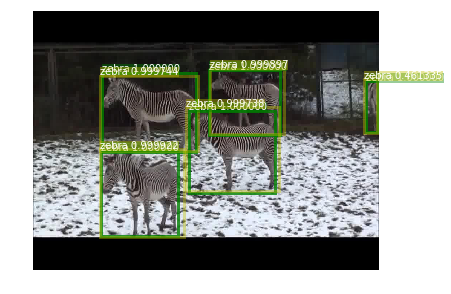

In [163]:
###Eg. output
_ = showBoxResult(4283,all_boxes,imdb)

### Save the figure to pdf

In [143]:
def save_det_fig(index_range,all_boxes,imdb,output_dir,ext,dpi,merge_pdfs = False):
    assert os.path.exists(output_dir), 'Error: output_dir does not exists.'
    if index_range is None:
        index_range = range(len(all_boxes[0]))
    for i in index_range:
        sys.stdout.write('%d/%d \r'%(i+1,len(index_range)))
        sys.stdout.flush()
        fig = showBoxResult(i,all_boxes,imdb,dpi=dpi)
        output_name = '%09d'%(i) + '.' + ext
        fig.savefig(os.path.join(output_dir, '{}'.format(output_name)), dpi=dpi)
        plt.close('all')
    if merge_pdfs:
        merge_out_path = '{}/VID_val_results.pdf'.format('./output/vis')
        if os.path.exists(merge_out_path):
            os.remove(merge_out_path)
        command = "pdfunite {}/*.pdf {}".format(output_dir,
                                                merge_out_path)
        subprocess.call(command, shell=True)

In [166]:
def merge_pdfs(output_dir='./output/vis/VID_val'):
    merge_out_path = '{}/VID_val_results.pdf'.format('./output/vis')
    if os.path.exists(merge_out_path):
        os.remove(merge_out_path)
    command = "pdfunite {}/*.pdf {}".format(output_dir,
                                            merge_out_path)
    subprocess.call(command, shell=True)

In [ ]:
save_det_fig(range(0,1000),all_boxes,imdb,output_dir='./output/vis/VID_val',ext='pdf',dpi=100)

In [154]:
merge_pdfs()

### Transform pickle boxes into Text format for evaluation

In [4]:
def Pickle2Text(picklePath, txtPath, imdb, threshold = 0.8):
    with open(picklePath) as f:
        all_boxes = pickle.load(f)
        num_images = len(imdb.image_index)
        print('num_images:',num_images)
        assert len(all_boxes[0])==num_images, 'Number of images not equal.'
    with open(txtPath,'w') as ft:
        for i in tqdm(range(len(imdb.image_index))):
            for j in range(len(imdb.classes)):
                if isinstance(all_boxes[j][i], np.ndarray):
                    for bbox in all_boxes[j][i]:
                        if bbox[-1]>threshold:
                            item_temp = '%d %d %f %f %f %f %f\n'%(
                                i+1,j,bbox[-1],bbox[0],bbox[1],bbox[2],bbox[3])
                            ft.write(item_temp)
                            #sys.stdout.write(item_temp)
                            #sys.stdout.flush()

In [5]:
from os import path as osp
model_name = 'rfcn_light_head'
picklePath = osp.join('output/res101/imagenetDETVID_val',model_name,'detections.pkl')
txtPath = osp.join('output/res101/imagenetDETVID_val',model_name,'detections.txt')
Pickle2Text(picklePath, txtPath, imdb, threshold=0.01)

  0%|          | 409/176126 [00:00<00:43, 4084.24it/s]

num_images: 176126


100%|██████████| 176126/176126 [00:53<00:00, 3280.18it/s]


In [6]:
model_name = 'rfcn_light_head_OHEM'
picklePath = osp.join('output/res101/imagenetDETVID_val',model_name,'detections.pkl')
txtPath = osp.join('output/res101/imagenetDETVID_val',model_name,'detections.txt')
Pickle2Text(picklePath, txtPath, imdb, threshold=0.01)

  0%|          | 349/176126 [00:00<00:50, 3484.11it/s]

num_images: 176126


100%|██████████| 176126/176126 [00:56<00:00, 3109.08it/s]


#### We can test how threshold of the score influence the final score.

In [47]:
def Boxes2Text(all_boxes, txtPath, imdb, threshold = 0.0):
    num_images = len(imdb.image_index)
    print('num_images:',num_images)
    assert len(all_boxes[0])==num_images, 'Number of images not equal.'
    with open(txtPath,'w') as ft:
        for i in tqdm(range(len(imdb.image_index))):
            for j in range(len(imdb.classes)):
                if isinstance(all_boxes[j][i], np.ndarray):
                    for bbox in all_boxes[j][i]:
                        if bbox[-1]>threshold:
                            item_temp = '%d %d %f %f %f %f %f\n'%(
                                i+1,j,bbox[-1],bbox[0],bbox[1],bbox[2],bbox[3])
                            ft.write(item_temp)
                            #sys.stdout.write(item_temp)
                            #sys.stdout.flush()

In [7]:
model_name = 'rfcn_light_head'
picklePath = osp.join('output/res101/imagenetDETVID_val',model_name,'detections.pkl')
with open(picklePath) as f:
    all_boxes = pickle.load(f)

In [171]:
threshold = 0.9
picklePath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections.pkl'
txtPath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections_%s.txt'%(str(threshold))
Boxes2Text(all_boxes, txtPath, imdb, threshold=threshold)

  0%|          | 460/176126 [00:00<00:38, 4594.67it/s]

num_images: 176126


100%|██████████| 176126/176126 [00:44<00:00, 3916.95it/s]


In [172]:
threshold = 0.8
picklePath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections.pkl'
txtPath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections_%s.txt'%(str(threshold))
Boxes2Text(all_boxes, txtPath, imdb, threshold=threshold)

  0%|          | 342/176126 [00:00<00:51, 3411.27it/s]

num_images: 176126


100%|██████████| 176126/176126 [00:47<00:00, 3719.18it/s]


In [173]:
threshold = 0.7
picklePath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections.pkl'
txtPath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections_%s.txt'%(str(threshold))
Boxes2Text(all_boxes, txtPath, imdb, threshold=threshold)

  0%|          | 388/176126 [00:00<00:45, 3878.15it/s]

num_images: 176126


100%|██████████| 176126/176126 [00:45<00:00, 3890.53it/s]


In [174]:
threshold = 0.6
picklePath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections.pkl'
txtPath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections_%s.txt'%(str(threshold))
Boxes2Text(all_boxes, txtPath, imdb, threshold=threshold)

  0%|          | 283/176126 [00:00<01:02, 2825.11it/s]

num_images: 176126


100%|██████████| 176126/176126 [00:44<00:00, 3944.05it/s]


In [175]:
threshold = 0.5
picklePath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections.pkl'
txtPath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections_%s.txt'%(str(threshold))
Boxes2Text(all_boxes, txtPath, imdb, threshold=threshold)

  0%|          | 236/176126 [00:00<01:14, 2358.91it/s]

num_images: 176126


100%|██████████| 176126/176126 [00:47<00:00, 3744.61it/s]


In [176]:
threshold = 0.4
picklePath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections.pkl'
txtPath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections_%s.txt'%(str(threshold))
Boxes2Text(all_boxes, txtPath, imdb, threshold=threshold)

  0%|          | 225/176126 [00:00<01:18, 2236.52it/s]

num_images: 176126


100%|██████████| 176126/176126 [00:47<00:00, 3729.85it/s]


In [177]:
threshold = 0.3
picklePath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections.pkl'
txtPath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections_%s.txt'%(str(threshold))
Boxes2Text(all_boxes, txtPath, imdb, threshold=threshold)

  0%|          | 396/176126 [00:00<00:44, 3953.56it/s]

num_images: 176126


100%|██████████| 176126/176126 [00:45<00:00, 3851.54it/s]


In [178]:
threshold = 0.2
picklePath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections.pkl'
txtPath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections_%s.txt'%(str(threshold))
Boxes2Text(all_boxes, txtPath, imdb, threshold=threshold)

  0%|          | 381/176126 [00:00<00:46, 3808.32it/s]

num_images: 176126


100%|██████████| 176126/176126 [00:47<00:00, 3735.84it/s]


In [179]:
threshold = 0.1
picklePath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections.pkl'
txtPath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections_%s.txt'%(str(threshold))
Boxes2Text(all_boxes, txtPath, imdb, threshold=threshold)

  0%|          | 312/176126 [00:00<00:56, 3112.15it/s]

num_images: 176126


100%|██████████| 176126/176126 [00:44<00:00, 3931.72it/s]


In [180]:
threshold = 0.0
picklePath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections.pkl'
txtPath = 'output/res101/imagenetDETVID_val/faster_rcnn_10/detections_%s.txt'%(str(threshold))
Boxes2Text(all_boxes, txtPath, imdb, threshold=threshold)

  0%|          | 169/176126 [00:00<01:44, 1682.75it/s]

num_images: 176126


100%|██████████| 176126/176126 [02:03<00:00, 1426.73it/s]


### Effect for Seq-NMS.

In [55]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
from model.utils.config import cfg
from roi_data_layer.roidb import combined_roidb
from model.nms.seq_nms import seq_nms
from os import path as osp
import numpy as np
from tqdm import tqdm
try:
    import cPickle as pickle
    print('import cPickle')
except:
    import pickle
    print('import python pickle')

import cPickle


In [11]:
imdbval_name = 'imagenetVID_val'
cfg.TRAIN.USE_FLIPPED = False
imdb, roidb, ratio_list, ratio_index = combined_roidb(imdbval_name, False)
imdb.competition_mode(on=True)
image_index, structured_indexes = imdb._image_index, imdb._structured_indexes

Total number of videos are: 555.
Total number of video images are: 176126.
Loaded dataset `imagenetVID_val` for training
Set proposal method: gt
Preparing training data...
/home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/imagenetVID_val_gt_roidb.pkl
imagenetVID_val gt roidb loaded from /home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/imagenetVID_val_gt_roidb.pkl
Image sizes loaded from /home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/imagenetVID_val_sizes.pkl
done
Total number of videos are: 555.
Total number of video images are: 176126.


In [39]:
def all_boxes_by_frame_index(all_boxes, indexes):
    new_all_boxes = []
    for cat_boxes in all_boxes:
        cat_b = []
        for index in indexes:
            cat_b.append(cat_boxes[index])
        new_all_boxes.append(cat_b)
    return new_all_boxes

In [40]:
def seqNMS(all_boxes):
    all_boxes_nms = [all_boxes[i] for i in range(1,len(all_boxes))]
    all_boxes_nms = [all_boxes[0]] + seq_nms(all_boxes_nms)
    return all_boxes_nms

In [52]:
def seqNMS_all_boxes(all_boxes):
    out_all_boxes = [[] for i in range(len(all_boxes))]
    for vid_id in range(len(structured_indexes)):
        print('vid:%04d/%04d\n'%(vid_id,len(structured_indexes)),end='')
        vid_indexes = structured_indexes[vid_id]
        vid_boxes = all_boxes_by_frame_index(all_boxes, vid_indexes)
        vid_boxes = seqNMS(vid_boxes)
        for cat_id in range(len(all_boxes)):
            out_all_boxes[cat_id].extend(vid_boxes[cat_id])
        for cat_id in range(len(all_boxes)-1):
            assert len(out_all_boxes[cat_id]) == len(out_all_boxes[cat_id+1]),'length of categories are not equal.'
    return out_all_boxes

In [ ]:
def Boxes2Text(all_boxes, txtPath, imdb, threshold = 0.0):
    num_images = len(imdb.image_index)
    print('num_images:',num_images)
    assert len(all_boxes[0])==num_images, 'Number of images not equal.'
    with open(txtPath,'w') as ft:
        for i in tqdm(range(len(imdb.image_index))):
            for j in range(len(imdb.classes)):
                if isinstance(all_boxes[j][i], np.ndarray):
                    for bbox in all_boxes[j][i]:
                        if bbox[-1]>threshold:
                            item_temp = '%d %d %f %f %f %f %f\n'%(
                                i+1,j,bbox[-1],bbox[0],bbox[1],bbox[2],bbox[3])
                            ft.write(item_temp)

In [ ]:
# Load boxes.
model_name = 'faster_rcnn_10'
picklePath = osp.join('output/res101/imagenetDETVID_val',model_name,'detections.pkl')
with open(picklePath) as f:
    all_boxes = pickle.load(f)

In [54]:
# NMS.
all_boxes_nms = seqNMS_all_boxes(all_boxes)
threshold = 0.0
txtPath = osp.join('output/res101/imagenetDETVID_val',model_name,'detections_%s_%f.txt'%('seq_nms',threshold))
pklPath = osp.join('output/res101/imagenetDETVID_val',model_name,'detections_%s_%f.pkl'%('seq_nms',threshold))
with open(pklPath, 'wb') as f:
    pickle.dump(all_boxes, f, pickle.HIGHEST_PROTOCOL)
Boxes2Text(all_boxes_nms, txtPath, imdb, threshold=threshold)

vid:0000/0555
vid:0001/0555
vid:0002/0555
vid:0003/0555
vid:0004/0555
vid:0005/0555
vid:0006/0555
vid:0007/0555
vid:0008/0555
vid:0009/0555
vid:0010/0555
vid:0011/0555
vid:0012/0555
vid:0013/0555
vid:0014/0555
vid:0015/0555
vid:0016/0555
vid:0017/0555
vid:0018/0555
vid:0019/0555
vid:0020/0555
vid:0021/0555
vid:0022/0555
vid:0023/0555
vid:0024/0555
vid:0025/0555
vid:0026/0555
vid:0027/0555
vid:0028/0555
vid:0029/0555
vid:0030/0555
vid:0031/0555
vid:0032/0555
vid:0033/0555
vid:0034/0555
vid:0035/0555
vid:0036/0555
vid:0037/0555
vid:0038/0555
vid:0039/0555
vid:0040/0555
vid:0041/0555
vid:0042/0555
vid:0043/0555
vid:0044/0555
vid:0045/0555
vid:0046/0555
vid:0047/0555
vid:0048/0555
vid:0049/0555
vid:0050/0555
vid:0051/0555
vid:0052/0555
vid:0053/0555
vid:0054/0555
vid:0055/0555
vid:0056/0555
vid:0057/0555
vid:0058/0555
vid:0059/0555
vid:0060/0555
vid:0061/0555
vid:0062/0555
vid:0063/0555
vid:0064/0555
vid:0065/0555
vid:0066/0555
vid:0067/0555
vid:0068/0555
vid:0069/0555
vid:0070/0555
vid:00

NameError: global name 'tqdm' is not defined

In [56]:
Boxes2Text(all_boxes_nms, txtPath, imdb, threshold=threshold)

  0%|          | 89/176126 [00:00<03:18, 885.76it/s]

num_images: 176126


100%|██████████| 176126/176126 [02:14<00:00, 1313.23it/s]


In [57]:
# Load boxes.
model_name = 'rfcn_light_head'
picklePath = osp.join('output/res101/imagenetDETVID_val',model_name,'detections.pkl')
with open(picklePath) as f:
    all_boxes = pickle.load(f)

In [ ]:
# NMS.
all_boxes_nms = seqNMS_all_boxes(all_boxes)
threshold = 0.0
txtPath = osp.join('output/res101/imagenetDETVID_val',model_name,'detections_%s_%f.txt'%('seq_nms',threshold))
pklPath = osp.join('output/res101/imagenetDETVID_val',model_name,'detections_%s_%f.pkl'%('seq_nms',threshold))
with open(pklPath, 'wb') as f:
    pickle.dump(all_boxes, f, pickle.HIGHEST_PROTOCOL)
Boxes2Text(all_boxes_nms, txtPath, imdb, threshold=threshold)

vid:0000/0555
vid:0001/0555
vid:0002/0555
vid:0003/0555
vid:0004/0555
vid:0005/0555
vid:0006/0555
vid:0007/0555
vid:0008/0555
vid:0009/0555
vid:0010/0555
vid:0011/0555
vid:0012/0555
vid:0013/0555
vid:0014/0555
vid:0015/0555
vid:0016/0555
vid:0017/0555
vid:0018/0555
vid:0019/0555
vid:0020/0555
vid:0021/0555
vid:0022/0555
vid:0023/0555
vid:0024/0555
vid:0025/0555
vid:0026/0555
vid:0027/0555
vid:0028/0555
vid:0029/0555
vid:0030/0555
vid:0031/0555
vid:0032/0555
vid:0033/0555
vid:0034/0555
vid:0035/0555
vid:0036/0555
vid:0037/0555
vid:0038/0555
vid:0039/0555
vid:0040/0555
vid:0041/0555
vid:0042/0555
vid:0043/0555
vid:0044/0555
vid:0045/0555
vid:0046/0555
vid:0047/0555
vid:0048/0555
vid:0049/0555
vid:0050/0555
vid:0051/0555
vid:0052/0555
vid:0053/0555
vid:0054/0555
vid:0055/0555
vid:0056/0555
vid:0057/0555
vid:0058/0555
vid:0059/0555
vid:0060/0555
vid:0061/0555
vid:0062/0555
vid:0063/0555
vid:0064/0555
vid:0065/0555
vid:0066/0555
vid:0067/0555
vid:0068/0555
vid:0069/0555
vid:0070/0555
vid:00